# ノック61：輸送最適化問題

In [1]:
# load library
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [2]:
# load data
df_tc = pd.read_csv('trans_cost.csv', index_col = '工場')
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [3]:
# init
np.random.seed(1)                          # set seed for random number
nw = len(df_tc.index)                      # number of warehouses
nf = len(df_tc.columns)                    # number of factories
pr = list(product(range(nw), range(nf)))   # all possible conbinationa of warehouses and factories

In [4]:
# check
print(nw)
print(nf)
print(pr)

3
4
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [5]:
# build model
m1 = model_min()
v1 = {(i,j) : LpVariable('v%d_%d'%(i,j), lowBound = 0) for i, j in pr}

In [6]:
# check
print(m1)
print(v1)
print(v1[1,1])

NoName:
MINIMIZE
None
VARIABLES

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}
v1_1


In [7]:
# add constraint conditions
m1 += lpSum(df_tc.iloc[i][j] * v1[i,j] for i, j in pr)

for i in range(nw):
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]

for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]

In [8]:
# check
m1

NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous

In [9]:
m1.solve()

1

In [10]:
v1.items()

dict_items([((0, 0), v0_0), ((0, 1), v0_1), ((0, 2), v0_2), ((0, 3), v0_3), ((1, 0), v1_0), ((1, 1), v1_1), ((1, 2), v1_2), ((1, 3), v1_3), ((2, 0), v2_0), ((2, 1), v2_1), ((2, 2), v2_2), ((2, 3), v2_3)])

In [11]:
# cost calculation
df_tr_sol = df_tc.copy()
total_cost = 0

for k, x in v1.items():
    print(k, x, value(x))
    i, j = k[0], k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j] * value(x)

print(df_tr_sol)
print("総輸送コスト：" + str(total_cost))

(0, 0) v0_0 28.0
(0, 1) v0_1 7.0
(0, 2) v0_2 0.0
(0, 3) v0_3 0.0
(1, 0) v1_0 0.0
(1, 1) v1_1 0.0
(1, 2) v1_2 31.0
(1, 3) v1_3 5.0
(2, 0) v2_0 0.0
(2, 1) v2_1 22.0
(2, 2) v2_2 0.0
(2, 3) v2_3 20.0
    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
総輸送コスト：1296.0


# ノック62：最適輸送ルートの可視化

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
# load data
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

In [14]:
df_tr

,F1,F2,F3,F4
工場,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


In [15]:
G = nx.Graph()

In [16]:
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

In [17]:
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            G.add_edge(df_pos.columns[i], df_pos.columns[j])
            if num_pre < len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]] * size
                elif(df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]] * size
                edge_weights.append(weight)

In [18]:
edge_weights

[0,
 0,
 2.8000000000000003,
 0.7000000000000001,
 0,
 0,
 0,
 0,
 0,
 3.1,
 0.5,
 0,
 2.2,
 0,
 2.0,
 0,
 0,
 0,
 0,
 0,
 0]

In [19]:
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0], df_pos[node][1])

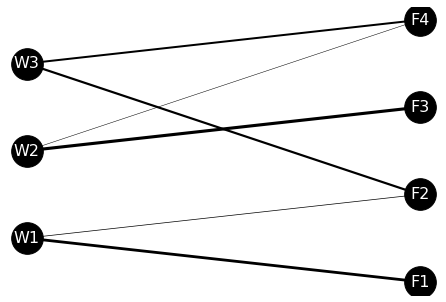

In [20]:
nx.draw(G, pos, with_labels = True, font_size = 16, node_size = 1000, node_color = 'k', font_color = 'w', width = edge_weights)
plt.show()

# ノック62_additional : もうちょっと良いかもしれないやり方

In [21]:
size = 0.1
df_tr_test = df_tr.copy()
df_tr_test['source'] = df_tr_test.index
df_tr_test = pd.melt(df_tr_test, id_vars = 'source', var_name = 'target', value_name = 'weight')
df_tr_test = df_tr_test.loc[df_tr_test['weight'] != 0]
df_tr_test['weight'] = df_tr_test['weight'] * size
df_tr_test

,source,target,weight
0,W1,F1,2.8
3,W1,F2,0.7
5,W3,F2,2.2
7,W2,F3,3.1
10,W2,F4,0.5
11,W3,F4,2.0


[('W1', 'F1', {'weight': 2.8000000000000003}), ('W1', 'F2', {'weight': 0.7000000000000001}), ('F2', 'W3', {'weight': 2.2}), ('W3', 'F4', {'weight': 2.0}), ('W2', 'F3', {'weight': 3.1}), ('W2', 'F4', {'weight': 0.5})]


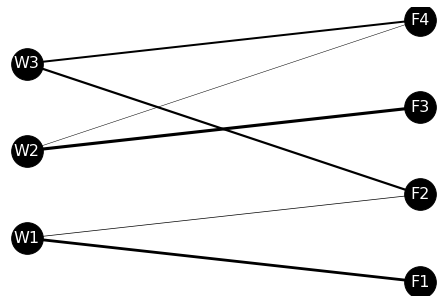

In [22]:
# test : build network from adjucency matrix(= tr_df)
# https://qiita.com/niship2/items/9d7e2b6ab2ca1be18eaf
Gtest = nx.from_pandas_edgelist(df_tr_test, edge_attr=True)
print(Gtest.edges(data=True))

nx.draw(Gtest,
        pos,
        with_labels = True,
        font_size = 16,
        node_size = 1000,
        node_color = 'k',
        font_color = 'w',
        width = list(nx.get_edge_attributes(Gtest,'weight').values()))

# ノック63 : 制約条件内に収まっているか確認

In [23]:
import pandas as pd
import numpy as np

In [24]:
df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

In [25]:
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum >= df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

In [26]:
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

In [27]:
print('需要条件計算結果：'+str(condition_demand(df_tr_sol, df_demand)))
print('供給条件計算結果：'+str(condition_supply(df_tr_sol, df_supply)))

需要条件計算結果：[1. 1. 1. 1.]
供給条件計算結果：[1. 1. 1.]


# ノック64 : 生産計画データ

In [28]:
import pandas as pd

In [29]:
df_material = pd.read_csv('product_plan_material.csv', index_col = '製品')
print(df_material)
df_profit = pd.read_csv('product_plan_profit.csv', index_col = '製品')
print(df_profit)
df_stock = pd.read_csv('product_plan_stock.csv', index_col = '項目')
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col = '製品')
print(df_plan)

     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
      利益
製品      
製品1  5.0
製品2  4.0
    原料1  原料2  原料3
項目               
在庫   40   80   50
      生産量
製品       
製品1    16
製品2     0


# ノック65 : 利益計算関数

In [30]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j] * df_plan.iloc[i][j]
    return profit

print('総利益：'+str(product_plan(df_profit, df_plan)))

総利益：80.0


# ノック66 : 生産最適化問題
- 今回は目的関数の最大化を制約条件下で行う

In [31]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

In [32]:
df = df_material.copy()
inv = df_stock

In [33]:
m = model_max()
v1 = {(i):LpVariable('v%d'%(i), lowBound = 0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j, i] * v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
    
m.solve()

1

In [34]:
print(v1)
print(m)

{0: v0, 1: v1}
NoName:
MAXIMIZE
5.0*v0 + 4.0*v1 + 0.0
SUBJECT TO
_C1: v0 + 2 v1 <= 40

_C2: 4 v0 + 4 v1 <= 80

_C3: 3 v0 + v1 <= 50

VARIABLES
v0 Continuous
v1 Continuous



In [35]:
df_plan_sol = df_plan.copy()

for k, x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print('総利益：'+str(value(m.objective)))

      生産量
製品       
製品1    15
製品2     5
総利益：95.0


# ノック67 : 制約条件内に収まっているか確認

In [36]:
def condition_stock(df_plan, df_material, df_stodk):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + ' 使用量：' + str(temp_sum) + ', 在庫：' + str(float(df_stock.iloc[0][i])))
    return flag

In [37]:
print('制約条件計算結果：' + str(condition_stock(df_plan_sol, df_material, df_stock)))

原料1 使用量：25.0, 在庫：40.0
原料2 使用量：80.0, 在庫：80.0
原料3 使用量：50.0, 在庫：50.0
制約条件計算結果：[1. 1. 1.]


# ノック68 : ロジスティクスネットワーク

In [38]:
import numpy as np
import pandas as pd

In [39]:
製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2, 2)

# 変数名を二バイト文字にして大丈夫？
# 後でpandasに入れる用だから良いにしても、あまりよくないのじゃないかと思う

In [40]:
tbdi = pd.DataFrame(((j, k) for j in 需要地 for k in 工場), columns = ['需要地', '工場'])
tbdi['輸送費'] = [1, 2, 3, 1]
print(tbdi)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1


In [41]:
tbde = pd.DataFrame(((j, i) for j in 需要地 for i in 製品), columns = ['需要地', '製品']) 
tbde['需要'] = [10, 10, 20, 20]
print(tbde)

  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20


In [42]:
tbfa = pd.DataFrame(((k, l, i, 0, np.inf) for k, nl in zip(工場, レーン) for l in range(nl) for i in 製品), columns = ['工場', 'レーン', '製品', '下限', '上限'])
tbfa['生産費'] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace = True)
tbfa.loc[4, '上限'] = 10
print(tbfa)

  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0


In [43]:
from ortoolpy import logistics_network

In [44]:
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa)
print(tbfa)
print(tbdi2)

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


# ノック69 : 輸送コストとその内訳

In [45]:
print(tbdi2)

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


In [46]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2['輸送費'].iloc[i] * tbdi2['ValX'].iloc[i]
print('総輸送コスト：'+str(trans_cost))

総輸送コスト：80.0


# ノック70 : 生産コストとその内訳

In [47]:
print(tbfa)

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0


In [48]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa['生産費'].iloc[i] * tbfa['ValY'].iloc[i]
print('総生産コスト：' + str(product_cost))

総生産コスト：120.0
